In [1]:
import sys
import os
import pandas as pd
import numpy as np
import importlib
sys.path.insert(1, '../../../sibyl')

directory = "data/"
dataset_filename = os.path.join(directory, "Model_Dataset_Version_01_01.csv")
features_filename = os.path.join(directory, "Design_Specification_DOUGLAS_v1.4.csv")
model_filename = os.path.join(directory, "weights_model_feb2019.csv")
threshold_filename = os.path.join(directory, "Performance_Matrix.csv")
feature_mappings_filename = os.path.join(directory, "mappings.csv")

First, we load in the base model, and the features that it uses.
For complete Sibyl use, we also need a model wrapper that converts the base model logits to 1-20 scores, but that model is not needed when computing feature contributions. Using the model wrapper instead of the model greatly increases run times.

In [2]:
# LOAD IN THE BASE MODEL

from sibyl.utils import model_utils, transformer
importlib.reload(model_utils)
importlib.reload(transformer)

weights_df = pd.read_csv(model_filename)
weights = weights_df["weight"]
model_features = weights_df["name"][1:]
base_model = model_utils.load_model_from_weights(weights, model_type="linear_regression")
feature_select = transformer.FeatureSelectTransformer(model_features)

(2, 460) (460,)


The cell below will load a Mappings object from the CSV. This object allows flexibility in include mappings format, and we will have factory methods to generate one from multiple different formats.

In [3]:
from sibyl.utils import mappings
importlib.reload(mappings)

mappings = mappings.Mappings.generate_mappings(dataframe=pd.read_csv(feature_mappings_filename))

In [4]:
# LOAD IN THE DATASET

dataset = pd.read_csv(dataset_filename)
dataset = dataset[model_features].astype("float")

C:\Users\Ola\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (222) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


 Now have everything we need to set up a FeatureContributionExplainer object, and begin using it.

In [5]:
import sibyl.explainers.local_feature_explanation as lfe
importlib.reload(lfe)

n = 100000
lce = lfe.FeatureContributionExplainer(base_model, dataset.sample(n), transformers=feature_select,
                                       algorithm="shap", fit_on_init=False)

We can now fit the contribution explainer, and time it

In [6]:
import time

start_time = time.time()
lce.fit_contributions()
end_time = time.time()

print("Total time taken to fit once (%i items): %f seconds" % (n, end_time-start_time))

Total time taken to fit once (100000 items): 0.055883 seconds


Now, we can get contributions, and time the process

In [7]:
d = 1000
daily_set = dataset.sample(d)

start_time = time.time()
contributions = lce.get_contributions(daily_set)
end_time = time.time()

print("Time time taken to get contributions on %s items: %f seconds" % (d, end_time-start_time))

Time time taken to get contributions on 1000 items: 0.006933 seconds


Now, we can take a look at the contributions found, and see if they make sense

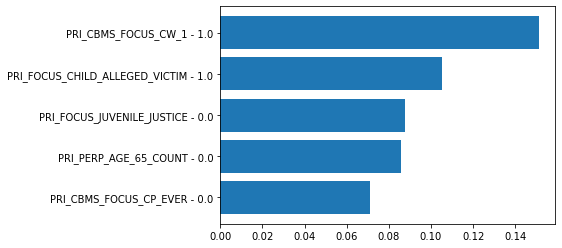

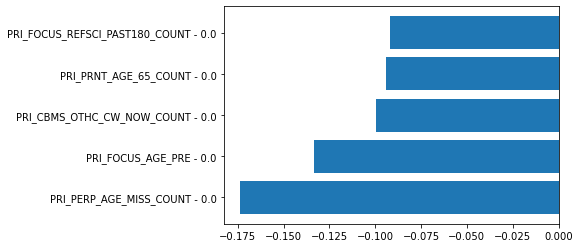

In [8]:
import matplotlib.pyplot as plt

entity = daily_set.iloc[0]
cont = contributions[0]

order = np.argsort(cont)
top_conts = cont[order[-5:]]
top_features = model_features[order[-5:]]
x = np.arange(5)
plt.barh(x, top_conts)
values = entity[top_features]
tick_labels = [top_features.iloc[i] + " - " + str(values.iloc[i]) for i in range(5)]
plt.yticks(x, tick_labels)
plt.show()

bottom_conts = cont[order[0:5]]
bottom_features = model_features[order[0:5]]
x = np.arange(5)
plt.barh(x, bottom_conts)
values = entity[bottom_features]
tick_labels = [bottom_features.iloc[i] + " - " + str(values.iloc[i]) for i in range(5)]
plt.yticks(x, tick_labels)
plt.show()

In [11]:
# time taken to convert to categorical
from sibyl.utils import transformer
importlib.reload(transformer)
import time

cat_transformer = transformer.MappingsDecoderTransformer(mappings)

start_time = time.time()
transformed = cat_transformer.transform(dataset)
end_time = time.time()
print(transformed.columns)

print("Time taken to encode full dataset: %f seconds" % (end_time-start_time))

Index(['PRI_CBMS_FOCUS_CD', 'PRI_CBMS_FOCUS_CH', 'PRI_CBMS_FOCUS_CP',
       'PRI_CBMS_FOCUS_CW', 'PRI_CBMS_FOCUS_DF', 'PRI_CBMS_FOCUS_EX',
       'PRI_CBMS_FOCUS_FM', 'PRI_CBMS_FOCUS_FP', 'PRI_CBMS_FOCUS_FS',
       'PRI_CBMS_FOCUS_FT',
       ...
       'PRI_OTHA_REF_NEGLECT_COUNT', 'PRI_OTHA_REF_EMOTIONAL_COUNT',
       'PRI_OTHA_REF_PHYSICAL_COUNT', 'PRI_OTHA_REF_DRUG_COUNT',
       'PRI_OTHA_REF_SEXUAL_COUNT', 'PRI_OTHA_REF_OTHER_COUNT',
       'PRI_OTHA_REF_DOMESTIC_VIOLENCE_COUNT', 'PRI_OTHA_CYF_ACTIVE',
       'PRI_OTHA_JUVENILE_JUSTICE', 'PRI_OTHA_COURT_ACTIVE'],
      dtype='object', length=358)
Time taken to encode full dataset: 0.764954 seconds
